In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn


Bad key savefig.frameon in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/yeemayseah/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably 

*7/26/2021*
### Recall vs applied read depth filter

#### Input

CSV generated by testing pipeline of all true and false calls from all variant callers (deepvariant, discosnp, freebayes, gatk, lancet, vardict; bcftools included, but DP reporting needs to be fixed).

Columns from VCF: CHROM, POS, REF, ALT, QUAL, AD (split into AD_REF and AD ALT), DP, GT (when calls are missed i.e., false negatives, GT value comes from the variants.py mutation list, which is set to 1 by default), RK_DISCOSNP (from INFO/Rk)

Added columns:
- TYPE: by comparing lengths of REF and ALT in checker.py
- BAM_DP: from intersection of two BED files, 1) generated from BAM using `bedtools genomecov -bga` and 2) from variants.py mutation list.
- TOOL and SAMPLE: user input parameter to checker.py
- TRUE_POS, FALSE_POS, FALSE_NEG: checker.py

*Note:* no DP field present in bcftools' VCF, so filtering is only based on BAM_DP.

In [12]:
all_calls = pd.read_csv('/Users/yeemayseah/Documents/Repos/mtb_amr/output/checked/TEST-H37Rv10-3IND_alltools_normalized_dp0_checked.csv')

In [13]:
all_calls

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,852.97,0.0,15.0,15.0,76,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
1,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,494.97,2.0,10.0,12.0,75,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,1076.97,0.0,20.0,20.0,50,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,1466.97,0.0,34.0,34.0,9,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,1353.97,0.0,30.0,30.0,42,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40852,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,192.00,9.0,48.0,50.0,56,1/1,hom,NaN,vardict,TEST-H37Rv10-3IND,1,0,0
40853,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,171.00,3.0,32.0,35.0,35,1/1,hom,NaN,vardict,TEST-H37Rv10-3IND,1,0,0
40854,NC_000962.3,4409772,C,CGCGTTGCAGCTTTA,INS,101.00,26.0,8.0,36.0,35,0/1,het,NaN,vardict,TEST-H37Rv10-3IND,0,1,0
40855,NC_000962.3,4410762,C,CCGCAAATAAGCCCGGTGTTGCAA,INS,193.00,9.0,50.0,53.0,51,1/1,hom,NaN,vardict,TEST-H37Rv10-3IND,1,0,0


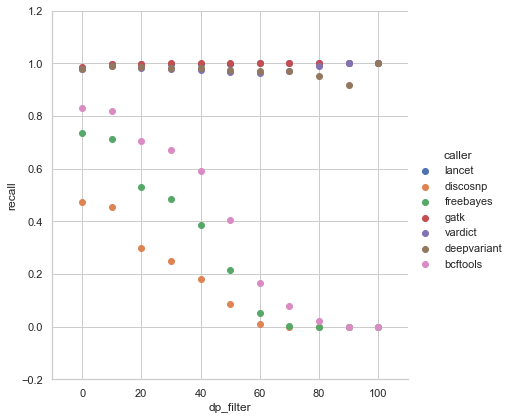

In [68]:
# Filtered on BAM_DP
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=bamdp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(-0.2,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

In [21]:
def sum_filtered(df, filter_column, min_value, variantlog):
    '''
    df: from csv generated by testing pipeline, via checker.py
    filter_column: string of column name to filter by
    min_value: minimum threshold for values to retain when filtering by filter_column
    variantlog: variant settings log generated by testing pipeline, via variants.py
    '''
    sums = {}
    filtered = df[df[filter_column] >= min_value]
    for tool in set(filtered['TOOL']):
        sums[tool] = [sum(filtered.loc[filtered['TOOL'] == tool, 'TRUE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_POS']),
                      sum(filtered.loc[filtered['TOOL'] == tool, 'FALSE_NEG'])]
    filtered_sums = pd.DataFrame(data=sums).T
    filtered_sums.reset_index(inplace=True)
    filtered_sums.rename(columns={'index': 'caller', 0:'true_pos', 1:'false_pos', 2: 'false_neg'}, inplace=True)
    filtered_sums['dp_filter'] = min_value
    filtered_sums['recall'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_neg'])
    filtered_sums['precision'] = filtered_sums['true_pos'] / (filtered_sums['true_pos'] + filtered_sums['false_pos'])
    # Sanity check: When min_value = 0, introduced mutations == postfilter mutations
    with open(variantlog, 'r') as log:
        varsettings = log.readlines()
    filtered_sums['total_mut_intro'] = int(varsettings[2].split(':')[-1].strip())
    filtered_sums['total_mut_postfilter'] = filtered_sums['true_pos'] + filtered_sums['false_neg']
    return filtered_sums

In [29]:
# Filtered on BAM_DP
bamdp_summary_df = pd.concat([dp0, bam_dp10, bam_dp20, bam_dp30, bam_dp40, 
                              bam_dp50, bam_dp60, bam_dp70, bam_dp80, bam_dp90, bam_dp100], ignore_index=True)
bamdp_summary_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4284,9470,72,0,0.983471,0.311473,4356,4356
1,discosnp,2066,2,2290,0,0.474288,0.999033,4356,4356
2,freebayes,3210,156,1146,0,0.736915,0.953654,4356,4356
3,gatk,4301,0,55,0,0.987374,1.000000,4356,4356
4,vardict,4263,604,93,0,0.978650,0.875899,4356,4356
...,...,...,...,...,...,...,...,...,...
72,freebayes,0,0,8,100,0.000000,NaN,4356,8
73,gatk,8,0,0,100,1.000000,1.000000,4356,8
74,vardict,8,1,0,100,1.000000,0.888889,4356,8
75,deepvariant,8,0,0,100,1.000000,1.000000,4356,8


In [22]:
dp0 = sum_filtered(all_calls, 'BAM_DP', 0, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp0

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4284,9470,72,0,0.983471,0.311473,4356,4356
1,discosnp,2066,2,2290,0,0.474288,0.999033,4356,4356
2,freebayes,3210,156,1146,0,0.736915,0.953654,4356,4356
3,gatk,4301,0,55,0,0.987374,1.000000,4356,4356
4,vardict,4263,604,93,0,0.978650,0.875899,4356,4356
5,deepvariant,4264,2,92,0,0.978880,0.999531,4356,4356
6,bcftools,3612,131,744,0,0.829201,0.965001,4356,4356


In [23]:
bam_dp10 = sum_filtered(all_calls, 'BAM_DP', 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp10

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,3807,9464,10,10,0.997380,0.286866,4356,3817
1,discosnp,1740,2,2077,10,0.455855,0.998852,4356,3817
2,freebayes,2725,153,1092,10,0.713911,0.946838,4356,3817
3,gatk,3814,0,3,10,0.999214,1.000000,4356,3817
4,vardict,3774,600,43,10,0.988735,0.862826,4356,3817
5,deepvariant,3777,1,40,10,0.989521,0.999735,4356,3817
6,bcftools,3126,62,691,10,0.818968,0.980552,4356,3817


In [24]:
bam_dp20 = sum_filtered(all_calls, 'BAM_DP', 20, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp20

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,2312,9438,6,20,0.997412,0.196766,4356,2318
1,discosnp,694,2,1624,20,0.299396,0.997126,4356,2318
2,freebayes,1233,151,1085,20,0.531924,0.890896,4356,2318
3,gatk,2316,0,2,20,0.999137,1.000000,4356,2318
4,vardict,2275,594,43,20,0.981450,0.792959,4356,2318
5,deepvariant,2282,1,36,20,0.984469,0.999562,4356,2318
6,bcftools,1630,30,688,20,0.703192,0.981928,4356,2318


In [25]:
bam_dp30 = sum_filtered(all_calls, 'BAM_DP', 30, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp30

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,2081,8797,5,30,0.997603,0.191304,4356,2086
1,discosnp,523,2,1563,30,0.250719,0.996190,4356,2086
2,freebayes,1010,143,1076,30,0.484180,0.875976,4356,2086
3,gatk,2085,0,1,30,0.999521,1.000000,4356,2086
4,vardict,2044,560,42,30,0.979866,0.784946,4356,2086
5,deepvariant,2051,0,35,30,0.983221,1.000000,4356,2086
6,bcftools,1399,4,687,30,0.670662,0.997149,4356,2086


In [26]:
bam_dp40 = sum_filtered(all_calls, 'BAM_DP', 40, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp40

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,1635,5387,2,40,0.998778,0.232840,4356,1637
1,discosnp,297,0,1340,40,0.181429,1.000000,4356,1637
2,freebayes,634,113,1003,40,0.387294,0.848728,4356,1637
3,gatk,1637,0,0,40,1.000000,1.000000,4356,1637
4,vardict,1598,396,39,40,0.976176,0.801404,4356,1637
5,deepvariant,1607,0,30,40,0.981674,1.000000,4356,1637
6,bcftools,970,2,667,40,0.592547,0.997942,4356,1637


In [27]:
bam_dp50 = sum_filtered(all_calls, 'BAM_DP', 50, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp60 = sum_filtered(all_calls, 'BAM_DP', 60, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp70 = sum_filtered(all_calls, 'BAM_DP', 70, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp80 = sum_filtered(all_calls, 'BAM_DP', 80, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp90 = sum_filtered(all_calls, 'BAM_DP', 90, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
bam_dp100 = sum_filtered(all_calls, 'BAM_DP', 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')

In [28]:
all_calls[all_calls['BAM_DP'] >= 100].sort_values('POS')

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
613,NC_000962.3,620894,G,GCAGCAAGGGGGAGTGCTGGTGACCGAGCATCCGAGGACGGGCGTG...,INS,695.97,0.0,13.0,13.0,101,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
13968,NC_000962.3,620894,G,GCAGCAAGGGGGAGTGCTGGTGACCGAGCATCCGAGGACGGGCGTG...,INS,17.70,0.0,33.0,72.0,101,1/1,hom,NaN,deepvariant,TEST-H37Rv10-3IND,1,0,0
23981,NC_000962.3,620894,G,GCAGCAAGGGGGAGTGCTGGTGACCGAGCATCCGAGGACGGGCGTG...,INS,35.68,24.0,23.0,47.0,101,0/1,het,NaN,lancet,TEST-H37Rv10-3IND,1,0,0
9484,NC_000962.3,620894,G,GCAGCAAGGGGGAGTGCTGGTGACCGAGCATCCGAGGACGGGCGTG...,INS,NaN,NaN,NaN,NaN,101,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
36604,NC_000962.3,620894,G,GCAGCAAGGGGGAGTGCTGGTGACCGAGCATCCGAGGACGGGCGTG...,INS,227.00,0.0,100.0,98.0,101,1/1,hom,NaN,vardict,TEST-H37Rv10-3IND,1,0,0
4985,NC_000962.3,620894,G,GCAGCAAGGGGGAGTGCTGGTGACCGAGCATCCGAGGACGGGCGTG...,INS,NaN,NaN,NaN,NaN,101,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,0,0,1
18326,NC_000962.3,620894,G,GCAGCAAGGGGGAGTGCTGGTGACCGAGCATCCGAGGACGGGCGTG...,INS,NaN,NaN,NaN,NaN,101,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
25655,NC_000962.3,1138434,G,T,SNP,0.57,56.0,1.0,57.0,102,0/1,het,NaN,lancet,TEST-H37Rv10-3IND,0,1,0
37270,NC_000962.3,1221744,G,GCGACCGGCAGTTCCGTTGATGTGTCGGCGCTTAAGGATCGGGCGACC,INS,213.00,31.0,75.0,102.0,115,1/0,het,NaN,vardict,TEST-H37Rv10-3IND,1,0,0
5591,NC_000962.3,1221744,G,GCGACCGGCAGTTCCGTTGATGTGTCGGCGCTTAAGGATCGGGCGACC,INS,NaN,NaN,NaN,NaN,115,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,0,0,1


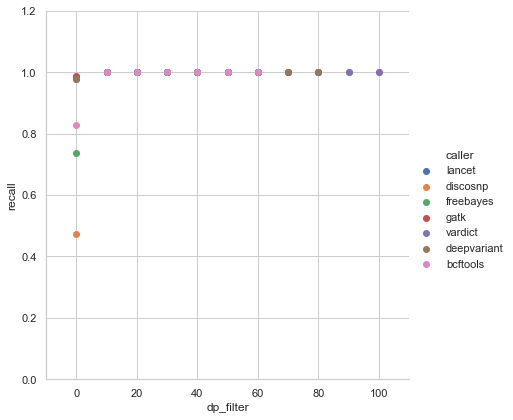

In [78]:
# Filtered on DP
seaborn.set(style='whitegrid')
fg = seaborn.FacetGrid(data=dp_summary_df, hue='caller', height=6, aspect=1, xlim=(-10,110), ylim=(0,1.2))
fg.map(plt.scatter, 'dp_filter', 'recall').add_legend()

In [77]:
# Filtered on DP
dp_summary_df = pd.concat([dp0, dp10, dp20, dp30, dp40,
                           dp50, dp60, dp70, dp80, dp90, dp100], ignore_index=True)
dp_summary_df

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4284,9470,72,0,0.983471,0.311473,4356,4356
1,discosnp,2066,2,2290,0,0.474288,0.999033,4356,4356
2,freebayes,3210,156,1146,0,0.736915,0.953654,4356,4356
3,gatk,4301,0,55,0,0.987374,1.000000,4356,4356
4,vardict,4263,604,93,0,0.978650,0.875899,4356,4356
...,...,...,...,...,...,...,...,...,...
56,deepvariant,1,0,0,80,1.000000,1.000000,4356,1
57,vardict,52,5,0,90,1.000000,0.912281,4356,52
58,discosnp,1,0,0,90,1.000000,1.000000,4356,1
59,vardict,11,0,0,100,1.000000,1.000000,4356,11


In [72]:
dp10 = sum_filtered(all_calls, 'DP', 10, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp10

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,4249,9296,0,10,1.0,0.313695,4356,4249
1,discosnp,2066,2,0,10,1.0,0.999033,4356,2066
2,freebayes,3089,151,0,10,1.0,0.953395,4356,3089
3,gatk,4125,0,0,10,1.0,1.000000,4356,4125
4,vardict,4255,598,0,10,1.0,0.876777,4356,4255
5,deepvariant,4258,1,0,10,1.0,0.999765,4356,4258
6,bcftools,3146,10,0,10,1.0,0.996831,4356,3146


In [73]:
dp20 = sum_filtered(all_calls, 'DP', 20, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp20

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,3976,8740,0,20,1.0,0.312677,4356,3976
1,discosnp,2054,2,0,20,1.0,0.999027,4356,2054
2,freebayes,2175,95,0,20,1.0,0.958150,4356,2175
3,gatk,3182,0,0,20,1.0,1.000000,4356,3182
4,vardict,4211,592,0,20,1.0,0.876744,4356,4211
5,deepvariant,4237,1,0,20,1.0,0.999764,4356,4237
6,bcftools,2125,4,0,20,1.0,0.998121,4356,2125


In [74]:
dp30 = sum_filtered(all_calls, 'DP', 30, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp30

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,3028,5971,0,30,1.0,0.336482,4356,3028
1,discosnp,1808,2,0,30,1.0,0.998895,4356,1808
2,freebayes,986,27,0,30,1.0,0.973346,4356,986
3,gatk,1879,0,0,30,1.0,1.000000,4356,1879
4,vardict,3671,588,0,30,1.0,0.861939,4356,3671
5,deepvariant,3923,1,0,30,1.0,0.999745,4356,3923
6,bcftools,961,0,0,30,1.0,1.000000,4356,961


In [75]:
dp40 = sum_filtered(all_calls, 'DP', 40, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp40

,caller,true_pos,false_pos,false_neg,dp_filter,recall,precision,total_mut_intro,total_mut_postfilter
0,lancet,1622,1798,0,40,1.0,0.474269,4356,1622
1,discosnp,894,2,0,40,1.0,0.997768,4356,894
2,freebayes,250,9,0,40,1.0,0.965251,4356,250
3,gatk,525,0,0,40,1.0,1.000000,4356,525
4,vardict,2386,516,0,40,1.0,0.822192,4356,2386
5,deepvariant,2599,0,0,40,1.0,1.000000,4356,2599
6,bcftools,242,0,0,40,1.0,1.000000,4356,242


In [76]:
dp50 = sum_filtered(all_calls, 'DP', 50, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp60 = sum_filtered(all_calls, 'DP', 60, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp70 = sum_filtered(all_calls, 'DP', 70, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp80 = sum_filtered(all_calls, 'DP', 80, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp90 = sum_filtered(all_calls, 'DP', 90, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')
dp100 = sum_filtered(all_calls, 'DP', 100, '/Users/yeemayseah/Documents/Repos/mtb_amr/logs/variants/TEST-H37Rv10-3IND.log')

*8/3/2021*
#### Why do discoSNP, FreeBayes, and bcftools recall values trend downwards when read depth filters are applied?

##### *Data*
- Introduced mutations: 4356 total (2196 INS + 2160 DEL)
- All FN calls: 2292 total (1628 INS + 664 DEL)
- 1 FN unique to DeepVariant; called by all other callers.
- 2291 of FN can be found in discoSNP, FreeBayes, or bcftools. 


#### Did filtering by BAM_DP matter?

Not for bcftools, DiscoSNP and FreeBayes, where 59-89% of FNs have BAM_DP >= 40. In comparison, the other callers only have 0-42% FNs with BAM_DP >= 40

**bcftools:** 876/983 (89%) FN have BAM_DP >= 40


**DiscoSNP:** 1340/2290 (59%) FN have BAM_DP >= 40


**FreeBayes:** 1003/1146 (88%) FN have BAM_DP >= 40


**GATK:** 0/55 FN have BAM_DP >= 40


**DeepVariant:** 30/92 FN (33%) have BAM_DP >= 40


**VarDict:** 39/93 FN (42%) have BAM_DP >= 40


**Lancet:** 2/72 FN (0.03%) have BAM_DP >= 40

In [34]:
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes') & (all_calls['BAM_DP'] >= 40)].shape

(1003, 18)

In [35]:
all_calls[all_calls['FALSE_NEG'] == 1].sort_values('POS')

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
8843,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
17713,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
4357,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,0,0,1
17714,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
8844,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13349,NC_000962.3,4405732,T,TCTCCTCGGTGGCTCGCACCGACAGGCCCTCCGCGA,INS,NaN,NaN,NaN,NaN,52,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
22067,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
22068,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
22069,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1


In [36]:
def count_mutations(df, caller):
    ins = 0
    dele = 0
    snp = 0
    for mut in df[df['TOOL'] == caller]['TYPE']:
        if mut == 'INS':
            ins += 1
        elif mut == 'DEL':
            dele += 1
        elif mut == 'SNP':
            snp += 1
    print('INS:', str(ins))
    print('DEL:', str(dele))
    print('SNP:', str(snp)) 
    print('TOTAL:', str(ins+dele+snp))

#### Introduced mutations

In [37]:
count_mutations(all_calls[(all_calls['TRUE_POS'] == 1) | (all_calls['FALSE_NEG'] == 1)], 'freebayes') # same numbers for any of the tools

INS: 2196
DEL: 2160
SNP: 0
TOTAL: 4356


#### FN: All callers
FN calls (2292 total) are both INS and DEL.

In [38]:
len(set(all_calls[all_calls['FALSE_NEG'] == 1]['POS']))

2292

In [39]:
set(all_calls[all_calls['FALSE_NEG'] == 1]['TYPE'])

{'DEL', 'INS'}

#### FN: By caller

In [40]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'bcftools')

INS: 724
DEL: 20
SNP: 0
TOTAL: 744


In [41]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'discosnp')

INS: 1628
DEL: 662
SNP: 0
TOTAL: 2290


In [42]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'freebayes')

INS: 1122
DEL: 24
SNP: 0
TOTAL: 1146


In [43]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'gatk')

INS: 36
DEL: 19
SNP: 0
TOTAL: 55


In [44]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'deepvariant')

INS: 72
DEL: 20
SNP: 0
TOTAL: 92


In [45]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'lancet')

INS: 43
DEL: 29
SNP: 0
TOTAL: 72


In [46]:
count_mutations(all_calls[all_calls['FALSE_NEG'] == 1], 'vardict')

INS: 74
DEL: 19
SNP: 0
TOTAL: 93


#### bcftools and FreeBayes

- 979 FN shared
- 4 FN bcftools only
- 167 FN FreeBayes only

In [47]:
# bcftools and FreeBayes
bcffreebayes_union = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='inner', on='POS')
bcffreebayes_union

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,...,NaN,75,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66,...,NaN,66,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87,...,NaN,87,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53,...,NaN,53,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76,...,NaN,76,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,NC_000962.3,4389541,T,TCGCGGTGATCACCGCCTCGGCGTGCGACACCACCGC,INS,NaN,NaN,NaN,NaN,47,...,NaN,47,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
740,NC_000962.3,4392532,C,CGCAACGGATCGTCGCCAAAGGACCCCGACGGCGCCGCCGGGGTG,INS,NaN,NaN,NaN,NaN,83,...,NaN,83,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
741,NC_000962.3,4395680,C,CCCCGTACCCAAATCCTGGTGCCGCCGGCGTCGTGGAGCCTGGCCAG,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
742,NC_000962.3,4402750,T,TCCGCCACCATCAAAGTTACCGACGCATCCTTTGCCACCGAC,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1


In [48]:
# bcftools only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y


In [49]:
# FreeBayes only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,12034,G,GCGTCCTGTAGGGCCTGCGGTAGGTTGGCCAC,INS,NaN,NaN,NaN,NaN,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NC_000962.3,20062,C,CCAGCGGTGATCTGGCCGCGCTGCCGTGAA,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,NC_000962.3,4362226,A,ACCGGGCAAATTCCTCGAACTGTGGCCCGACTGTGACC,INS,NaN,NaN,NaN,NaN,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135,NC_000962.3,4373306,C,CGTGGCGTTCCAAGACCACCCACCAG,INS,NaN,NaN,NaN,NaN,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,NC_000962.3,4374352,T,TACCTGAATTGTGTCTGCCACGGGCCCTTCTCC,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1139,NC_000962.3,4383520,G,GCTGCATTGCTCCCTGCCCCGCTTGCATGGC,INS,NaN,NaN,NaN,NaN,47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### bcftools and DiscoSNP
- 982 FN shared
- 1 FN bcftools only
- 1308 FN DiscoSNP only

In [50]:
# bcftools and DiscoSNP
bcfdiscosnp_union = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='inner', on='POS')
bcfdiscosnp_union

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,...,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66,...,NaN,66,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87,...,NaN,87,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53,...,NaN,53,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76,...,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,NC_000962.3,4389541,T,TCGCGGTGATCACCGCCTCGGCGTGCGACACCACCGC,INS,NaN,NaN,NaN,NaN,47,...,NaN,47,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
740,NC_000962.3,4392532,C,CGCAACGGATCGTCGCCAAAGGACCCCGACGGCGCCGCCGGGGTG,INS,NaN,NaN,NaN,NaN,83,...,NaN,83,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
741,NC_000962.3,4395680,C,CCCCGTACCCAAATCCTGGTGCCGCCGGCGTCGTGGAGCCTGGCCAG,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
742,NC_000962.3,4402750,T,TCCGCCACCATCAAAGTTACCGACGCATCCTTTGCCACCGAC,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1


In [51]:
# bcftools only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y


In [52]:
# DiscoSNP only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,NaN,NaN,NaN,NaN,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,NaN,NaN,NaN,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,NC_000962.3,4404765,C,CCAACTCTTCAATCA,INS,NaN,NaN,NaN,NaN,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2286,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2287,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2288,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### FreeBayes and DiscoSNP
- 1145 FN shared
- 1 FN FreeBayes only
- 1145 FN DiscoSNP only

In [53]:
# FreeBayes and DiscoSNP
freedisco_union = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='inner', on='POS')
freedisco_union

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76,...,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75,...,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50,...,NaN,50,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52,...,NaN,52,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,12034,G,GCGTCCTGTAGGGCCTGCGGTAGGTTGGCCAC,INS,NaN,NaN,NaN,NaN,61,...,NaN,61,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1140,NC_000962.3,4392532,C,CGCAACGGATCGTCGCCAAAGGACCCCGACGGCGCCGCCGGGGTG,INS,NaN,NaN,NaN,NaN,83,...,NaN,83,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1141,NC_000962.3,4395680,C,CCCCGTACCCAAATCCTGGTGCCGCCGGCGTCGTGGAGCCTGGCCAG,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1142,NC_000962.3,4400729,A,AGCGCGGCTGCTGGGCTATCTCAACACC,INS,NaN,NaN,NaN,NaN,37,...,NaN,37,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1143,NC_000962.3,4402750,T,TCCGCCACCATCAAAGTTACCGACGCATCCTTTGCCACCGAC,INS,NaN,NaN,NaN,NaN,77,...,NaN,77,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1


In [54]:
# FreeBayes only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
388,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# DiscoSNP only
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,NaN,NaN,NaN,NaN,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NC_000962.3,23007,G,GGGCCAATGCGGCAATCA,INS,NaN,NaN,NaN,NaN,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NC_000962.3,37041,G,GACACCGCGGCCGCCGCC,INS,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NC_000962.3,46309,GAACGGCAAGGTACGTGGCCGGGTGGTGGTGGCCGCC,G,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,NC_000962.3,4404765,C,CCAACTCTTCAATCA,INS,NaN,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2286,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2287,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2288,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### bcftools
All FN are shared with DiscoSNP, FreeBayes, or both.

In [56]:
freedisco_all = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS')
freedisco_all

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,957,A,AACCCGCTTTGAGTGGGGGCTGATCACTGACGTACAACC,INS,NaN,NaN,NaN,NaN,76.0,...,NaN,76.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
1,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75.0,...,NaN,75.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2,NC_000962.3,2966,C,CGTGCGGCTTTCTGCGGGTGCCGATGATGT,INS,NaN,NaN,NaN,NaN,50.0,...,NaN,50.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
3,NC_000962.3,9982,C,CCGTGGGGGCGCACATCGGGCAG,INS,NaN,NaN,NaN,NaN,52.0,...,NaN,52.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
4,NC_000962.3,12034,G,GCGTCCTGTAGGGCCTGCGGTAGGTTGGCCAC,INS,NaN,NaN,NaN,NaN,61.0,...,NaN,61.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2286,NaN,4404765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2287,NaN,4407714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2288,NaN,4408757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,56.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0
2289,NaN,4409770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,35.0,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0.0,0.0,1.0


In [57]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')],
         freedisco_all, how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y


#### FreeBayes
All FN are shared with DiscoSNP,bcftools, or both

In [58]:
bcfdiscosnp_all = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS')
bcfdiscosnp_all

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75.0,...,NaN,75,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66.0,...,NaN,66,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87.0,...,NaN,87,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53.0,...,NaN,53,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76.0,...,NaN,76,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285,NaN,4404765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,30,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2286,NaN,4407714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,44,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2287,NaN,4408757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,56,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1
2288,NaN,4409770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,35,1,hom,NaN,discosnp,TEST-H37Rv10-3IND,0,0,1


In [59]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')],
         bcfdiscosnp_all, how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
388,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### DiscoSNP
1141 FN are unique to DiscoSNP.

In [60]:
bcffree_all = pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         how='outer', on='POS')
bcffree_all

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
0,NC_000962.3,1963,C,CACGCGTCATGGGCATTCGTCGTTGGCAGTCCCCACGCTAGCGGGG...,INS,NaN,NaN,NaN,NaN,75.0,...,NaN,75,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1,NC_000962.3,19080,G,GTATCCGACGGTGGTTGAGATATTGGCTAGGTCCGGTCCCTTGAGGC,INS,NaN,NaN,NaN,NaN,66.0,...,NaN,66,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
2,NC_000962.3,28979,C,CCAGGCGGGTGTTCACCTGGATCGCACCACCTATCAACAGATCAACGA,INS,NaN,NaN,NaN,NaN,87.0,...,NaN,87,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
3,NC_000962.3,30011,C,CCGCGCAGCTCGATCTGCAGGTCGTCTCGGCAATTCTGAA,INS,NaN,NaN,NaN,NaN,53.0,...,NaN,53,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
4,NC_000962.3,36042,C,CCCATGCGCTGGGCGTGCTCGGCCCCGACGGGCGAGGAGCTTCG,INS,NaN,NaN,NaN,NaN,76.0,...,NaN,76,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,NaN,4362226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,68,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1142,NaN,4373306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,54,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1143,NaN,4374352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,50,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1
1144,NaN,4383520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,47,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,0,0,1


In [61]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')],
         bcffree_all, how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
3,NC_000962.3,3938,CGCCGGAATCGCGATCGGCGTCTATCGGTTATCGGG,C,DEL,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_000962.3,4951,G,GGCCTCGCCATATT,INS,NaN,NaN,NaN,NaN,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NC_000962.3,23007,G,GGGCCAATGCGGCAATCA,INS,NaN,NaN,NaN,NaN,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NC_000962.3,37041,G,GACACCGCGGCCGCCGCC,INS,NaN,NaN,NaN,NaN,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NC_000962.3,46309,GAACGGCAAGGTACGTGGCCGGGTGGTGGTGGCCGCC,G,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2284,NC_000962.3,4404765,C,CCAACTCTTCAATCA,INS,NaN,NaN,NaN,NaN,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2286,NC_000962.3,4407714,T,TTTGATGGCGAGCATTCGCCC,INS,NaN,NaN,NaN,NaN,44.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2287,NC_000962.3,4408757,G,GTCGCCTGCAATCTCGCCCTCGGCGACCAAT,INS,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2288,NC_000962.3,4409770,C,CTCGCGTTGCAGCTT,INS,NaN,NaN,NaN,NaN,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Only 1 FN call shared by FreeBayes and bcftools, is not in DiscoSNP

In [62]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'freebayes')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
388,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,NaN,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'bcftools')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y


In [64]:
all_calls[(all_calls['POS'] == 1497101) & (all_calls['TOOL'] == 'discosnp')]

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
19193,NC_000962.3,1497101,TCGCCACCCGATGCTGGCCGCCAGCAACGAGCTCGGCCTGGTCACC...,T,DEL,NaN,1.0,37.0,38.0,12,1/1,hom,0.97876,discosnp,TEST-H37Rv10-3IND,1,0,0


Out of DiscoSNP's 2290 FN calls, 1628 INS + 662 DEL

In [65]:
all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')].groupby('TYPE').count()

,CHROM,POS,REF,ALT,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
TYPE,,,,,,,,,,,,,,,,,
DEL,662,662,662,662,0,0,0,0,662,662,662,0,662,662,662,662,662
INS,1628,1628,1628,1628,0,0,0,0,1628,1628,1628,0,1628,1628,1628,1628,1628


#### DeepVariant
1 FN from DeepVariant (DEL at POS 372121), not shared with any other caller.

In [66]:
pd.merge(all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'deepvariant')], 
         all_calls[(all_calls['FALSE_NEG'] == 1) & (all_calls['TOOL'] == 'discosnp')], 
         how='outer', on='POS', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])

,CHROM_x,POS,REF_x,ALT_x,TYPE_x,QUAL_x,AD_REF_x,AD_ALT_x,DP_x,BAM_DP_x,...,DP_y,BAM_DP_y,GT_y,ZYG_y,RK_DISCOSNP_y,TOOL_y,SAMPLE_y,TRUE_POS_y,FALSE_POS_y,FALSE_NEG_y
2,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,NaN,NaN,NaN,NaN,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
all_calls[all_calls['POS'] == 372131]

,CHROM,POS,REF,ALT,TYPE,QUAL,AD_REF,AD_ALT,DP,BAM_DP,GT,ZYG,RK_DISCOSNP,TOOL,SAMPLE,TRUE_POS,FALSE_POS,FALSE_NEG
367,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,1582.97,0.0,37.0,37.0,10,1,hom,NaN,gatk,TEST-H37Rv10-3IND,1,0,0
4737,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,228.39,1.0,30.0,31.0,10,1,hom,NaN,bcftools,TEST-H37Rv10-3IND,1,0,0
9230,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,241.34,0.0,18.0,18.0,10,1,hom,NaN,freebayes,TEST-H37Rv10-3IND,1,0,0
13722,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,NaN,NaN,NaN,NaN,10,1,hom,NaN,deepvariant,TEST-H37Rv10-3IND,0,0,1
18080,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,NaN,3.0,37.0,40.0,10,1/1,hom,0.88203,discosnp,TEST-H37Rv10-3IND,1,0,0
23187,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,111.39,0.0,20.0,20.0,10,1/1,hom,NaN,lancet,TEST-H37Rv10-3IND,1,0,0
36320,NC_000962.3,372131,TGCTGCCCGAGTTGAACAGGCCGATGTTTCCGC,T,DEL,160.00,0.0,22.0,31.0,10,1/0,het,NaN,vardict,TEST-H37Rv10-3IND,1,0,0
